In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Feature Extraction and Transfer Learning with VGG16: Without Fine-tuning vs. With Fine-tuning 🌟

# 🐦 Downloading the Indian Birds Dataset 📥
Using kagglehub, we’ll download the latest version of the Indian Birds dataset from Kaggle directly into our environment:

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ichhadhari/indian-birds")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/indian-birds


## 🔧 Importing Libraries for Image Classification 🖼️
In this project, we're importing various libraries to help with image processing, data handling, model building, and training. Here's a quick overview of each:

In [16]:
import numpy as np
import pandas as pd
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

## 🕊️ Creating a Smaller Dataset for Efficient Processing 📂
Since the Indian Birds dataset has nearly **300,000 images**, we're copying only **400 images per category** to reduce computational load. This smaller dataset will allow us to experiment and train models more efficiently on our system.

In [17]:
#### import os
import shutil

# Define paths
source_path = "/kaggle/input/indian-birds/Birds_25/train"  # Original dataset path
destination_path = "/kaggle/working/limited_dataset2"  # Destination for 400 images per folder

# Create destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Iterate over each folder (bird category) in the source path
for folder_name in os.listdir(source_path):
    folder_source_path = os.path.join(source_path, folder_name)
    folder_dest_path = os.path.join(destination_path, folder_name)

    # Ensure we're working with directories only
    if os.path.isdir(folder_source_path):
        os.makedirs(folder_dest_path, exist_ok=True)  # Create destination folder if not exists

        # List all images in the folder
        images = [f for f in os.listdir(folder_source_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Take the first 400 images (or all if fewer than 500 exist)
        for image_name in images[:400]:
            source_image_path = os.path.join(folder_source_path, image_name)
            dest_image_path = os.path.join(folder_dest_path, image_name)

            # Copy the image to the destination folder
            shutil.copy(source_image_path, dest_image_path)

        print(f"Copied {min(400, len(images))} images from {folder_name}")

print("All folders processed successfully!")

Copied 400 images from Common-Rosefinch
Copied 400 images from Asian-Green-Bee-Eater
Copied 400 images from Common-Kingfisher
Copied 400 images from Jungle-Babbler
Copied 400 images from White-Wagtail
Copied 400 images from Indian-Roller
Copied 400 images from Brown-Headed-Barbet
Copied 400 images from Common-Tailorbird
Copied 400 images from Rufous-Treepie
Copied 400 images from White-Breasted-Waterhen
Copied 400 images from Forest-Wagtail
Copied 400 images from Common-Myna
Copied 400 images from Sarus-Crane
Copied 400 images from House-Crow
Copied 400 images from Hoopoe
Copied 400 images from Coppersmith-Barbet
Copied 400 images from Cattle-Egret
Copied 400 images from Indian-Peacock
Copied 400 images from White-Breasted-Kingfisher
Copied 400 images from Gray-Wagtail
Copied 400 images from Ruddy-Shelduck
Copied 400 images from Red-Wattled-Lapwing
Copied 400 images from Indian-Pitta
Copied 400 images from Indian-Grey-Hornbill
Copied 400 images from Northern-Lapwing
All folders process

## 🖼️ Preparing Image Data for Training with Augmentation 📊
* **Data Augmentation Setup:** Defined ImageDataGenerator to apply various transformations (e.g., rotation, zoom, flips) for making the model more robust and to prevent overfitting.
* **Training and Validation Split:** Used 80% of images for training and 20% for validation by setting validation_split=0.2.
* **Image Resizing and Scaling:** Resized images to 256x256 pixels and scaled pixel values to a [0,1] range with rescale=1./255 for faster, standardized input.
* **Batching and Class Mode:** Loaded images in batches of 64 with categorical mode for multi-class classification across 25 bird species.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_set_path = '/kaggle/working/limited_dataset2'

# Set up the ImageDataGenerator with 20% of data split between validation and test
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Total split for validation and test
)

# Training generator (80% of data)
train_generator = datagen.flow_from_directory(
    training_set_path,
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Validation generator (10% of data)
validation_generator = datagen.flow_from_directory(
    training_set_path,
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Create a separate ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Test generator (10% of data)
test_generator = test_datagen.flow_from_directory(
    training_set_path,
    target_size=(240, 240),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 8000 images belonging to 25 classes.
Found 2000 images belonging to 25 classes.
Found 1000 images belonging to 25 classes.


## Display Sample Images from Training, Validation, and Test Sets 📸
* This code defines a function to visualize sample images from data generators. It allows for a quick inspection of the images used in the training, validation, and testing phases of a model.

**Sample Images from the Training Set 🔍**
* This part of the code showcases a selection of images from the training dataset, providing insight into the quality and diversity of the training data.

**Sample Images from the Validation Set ✅**
* Here, we visualize images from the validation dataset. This helps to evaluate how well the model may perform on unseen data during training.

**Sample Images from the Test Set 🧪**
* Finally, this section displays images from the test dataset, allowing for a final check of the images that will be used to assess the model's performance after training is complete.

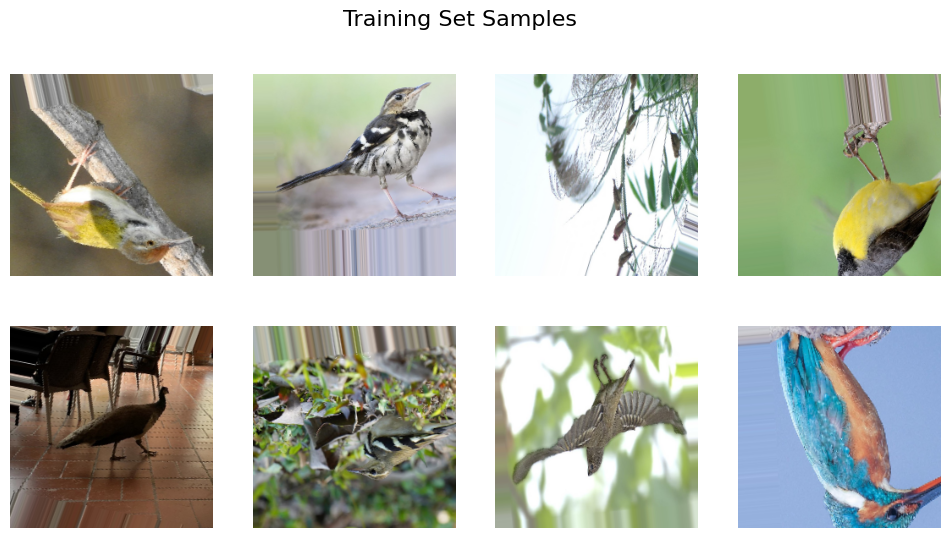

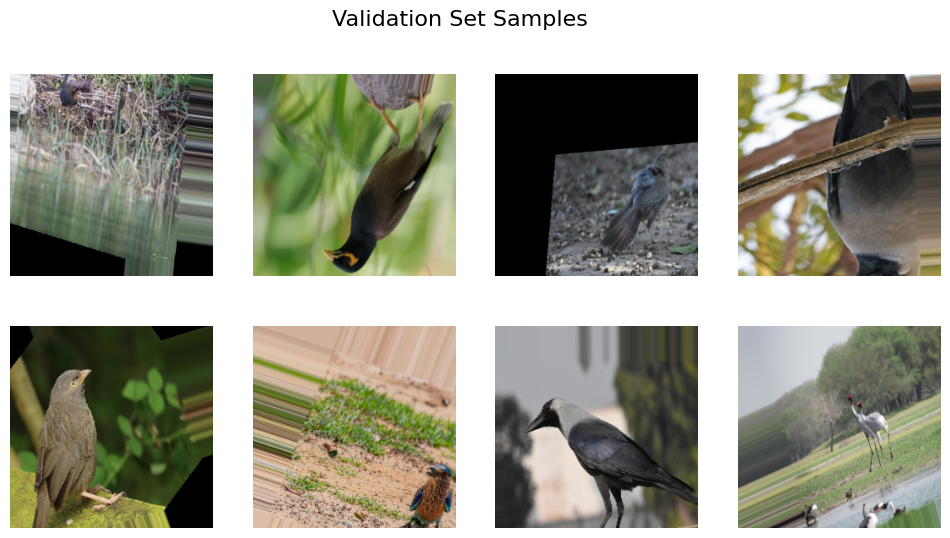

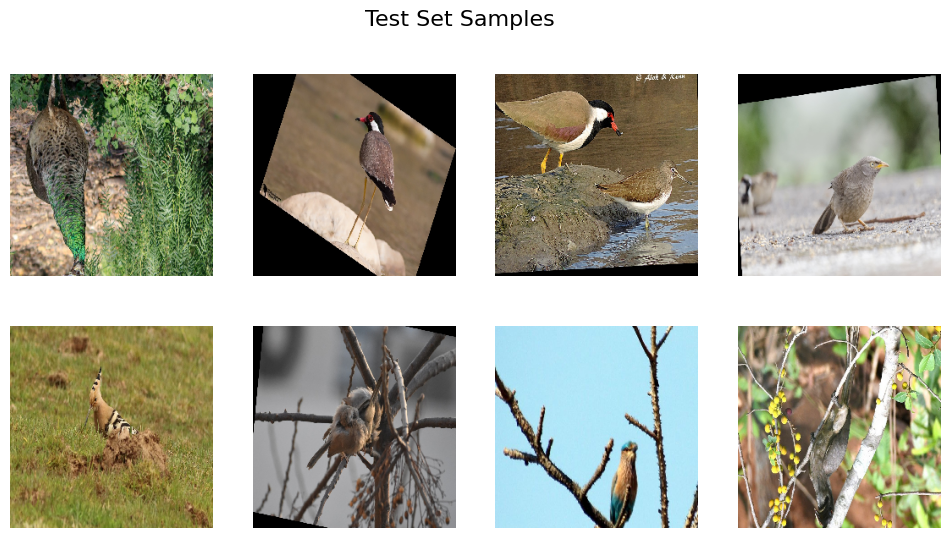

In [19]:

import matplotlib.pyplot as plt

def show_sample_images(generator, title):
    # Get a batch of images and labels
    images, labels = next(generator)
    
    # Set up the figure
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    # Display the first 8 images from the batch
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        
    plt.show()

# Show sample images from each generator
show_sample_images(train_generator, "Training Set Samples")
show_sample_images(validation_generator, "Validation Set Samples")
show_sample_images(test_generator, "Test Set Samples")


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
import matplotlib.image as mpimg
import math
import os
import warnings
warnings.filterwarnings('ignore')

## Feature Extraction Model Using VGG16 for Multi-Class Classification: Without Fine-tuning 🚫
**Overview 🌐**
**Model Architecture:** Utilize the VGG16 architecture as a feature extractor by leveraging its pre-trained weights from ImageNet while keeping all layers frozen (non-trainable).
**Input Shape:** The model accepts images of size 240x240 pixels with three color channels (RGB).

**This model leverages VGG16 as a feature extractor for a 25-class classification task:**

* **VGG16 Base as Feature Extractor🔧:** Initializes VGG16 without top layers to extract high-level features from images. Custom weights are loaded to enhance feature learning.
 
* **Layer Freezing🧊:** All layers in VGG16 are frozen to retain its pre-learned features, optimizing training speed.

### Custom Classification Head🧠:

* Flatten layer to reshape VGG16’s output for classification.
* Dense layer with 256 units to adapt features to the specific classification task.
* Dropout (50%) to prevent overfitting.
* Softmax output layer for the 25 target classes.

In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Initialize the VGG16 model without the top layers
conv_base = VGG16(weights=None, include_top=False, input_shape=(240, 240, 3))

# Load the custom weights from the specified path
weights_path = '/kaggle/input/vgg16/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop (4).h5'
conv_base.load_weights(weights_path)

# Freeze all layers in the base model
for layer in conv_base.layers:
    layer.trainable = False

# Create a new Sequential model and add layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(25, activation='softmax'))

# Ensure the model is built by running an input through it, if necessary
model.build(input_shape=(None, 240, 240, 3))

# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,143,897 (80.66 MB)

 Trainable params: 6,429,209 (24.53 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
import matplotlib.image as mpimg
import math
import os
import warnings
warnings.filterwarnings('ignore')

## Compile the Model with Optimizer Configuration ⚙️💻
* In this section, we compile the model by specifying the loss function, optimizer, and evaluation metrics.
* Using categorical crossentropy as the loss function is ideal for multi-class classification tasks.  * The Adam optimizer is chosen for its efficiency and adaptability in training deep learning models. * Here, the learning rate is set to 2e-5, which controls how much to adjust the model weights with respect to the loss gradient. 
* This careful configuration helps improve the model's performance during training! 🚀📈

In [14]:
from tensorflow.keras import optimizers

# Update optimizer to use 'learning_rate' instead of 'lr'
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)


## Train the Model 🏋️‍♂️📊
In this section, we initiate the training process for the model using the fit method. The training parameters are set as follows:

* **Batch Size:** Set to 32, meaning the model will process 32 samples at a time before updating the weights. This helps in efficient memory usage and speeds up the training process.
* **Epochs:** Set to 20, indicating that the model will go through the entire training dataset 20 times to learn and improve.

In [17]:
BATCH_SIZE = 32
EPOCHS = 20


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 804ms/step - acc: 0.3701 - loss: 2.1063 - val_acc: 0.4520 - val_loss: 1.9445
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 793ms/step - acc: 0.3917 - loss: 2.0562 - val_acc: 0.4620 - val_loss: 1.9141
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 790ms/step - acc: 0.3992 - loss: 2.0147 - val_acc: 0.4710 - val_loss: 1.8861
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 794ms/step - acc: 0.4164 - loss: 1.9775 - val_acc: 0.4745 - val_loss: 1.8498
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 793ms/step - acc: 0.4315 - loss: 1.9390 - val_acc: 0.4955 - val_loss: 1.8158
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 247s 948ms/step - acc: 0.4255 - loss: 1.9170 - val_acc: 0.5015 - val_loss: 1.7944
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 207s 789ms/step - acc: 0.4428 - loss: 1.8986 - val_acc: 0.5030 - val_loss: 1.7711
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 207s 789ms/step - acc: 0.4510 - loss: 1.8360 - val_acc: 0.5150 - val_loss: 1.7455
Epoch 9/20
250/250 ━━━━━

## Save the Trained Model 💾🦜
* In this step, we save the trained model to a file for future use. 
* The model is saved in the HDF5 format with the filename bird_vgg_recognition_model.h5. 
* This allows for easy loading and deployment later without needing to retrain the model.

In [26]:

model.save('/kaggle/working/bird_vgg_recognition_model.h5')



# List files in the /kaggle/working/ directory
print(os.listdir('/kaggle/working/'))


['bird_vgg16model.h5', 'bird_vgg_recognition_model.h5', 'bird_vgg16model.keras', '.virtual_documents', 'limited_dataset2']


## Model Predictions and Evaluation 📊🔍
* In this section, we evaluate the performance of the trained model on the test dataset by making predictions and comparing them with the actual labels.

## Make Predictions on Test Set 🖼️
* We start by predicting the classes of the images in the test set:

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step 


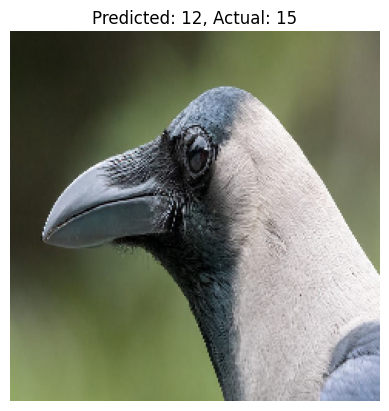

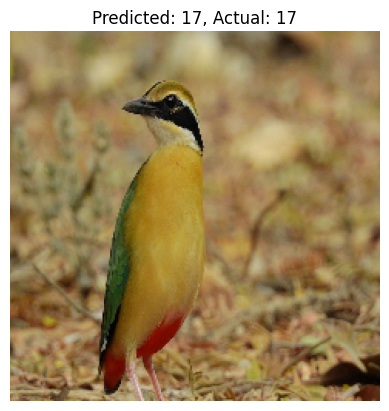

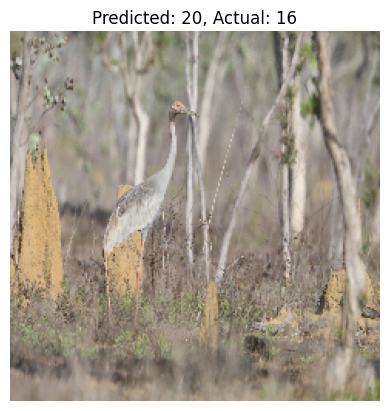

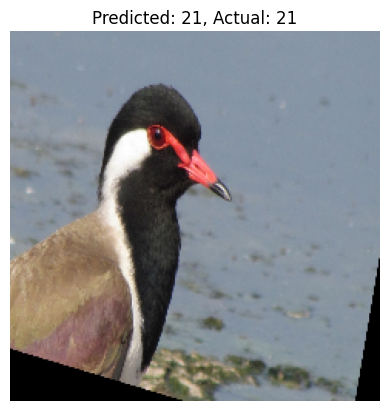

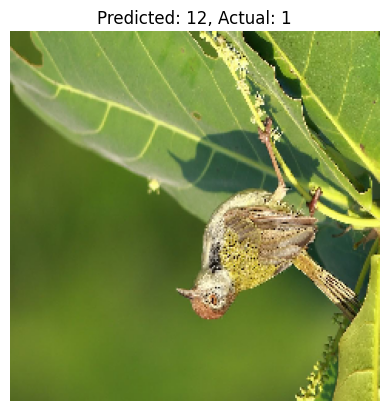

Accuracy on test set: 63.25%


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples in the test generator
num_samples = test_generator.samples

# Initialize an empty list to store predictions and actual labels
predictions_list = []
labels_list = []

# Make predictions on the test set
for i in range(num_samples // test_generator.batch_size):
    # Get a batch of images and labels
    imgs, labels = next(test_generator)
    
    # Make predictions on the batch
    preds = model.predict(imgs)
    
    # Store the predicted classes and actual classes
    predicted_classes = np.argmax(preds, axis=1)  # Get the predicted class indices
    predictions_list.extend(predicted_classes)
    labels_list.extend(np.argmax(labels, axis=1))  # Get actual class indices

# Convert lists to arrays for easier manipulation
predictions_array = np.array(predictions_list)
labels_array = np.array(labels_list)

# Display some of the predictions
for i in range(5):  # Display the first 5 predictions
    plt.imshow(imgs[i])  # Show the image
    plt.title(f'Predicted: {predictions_array[i]}, Actual: {labels_array[i]}')  # Title with prediction and actual
    plt.axis('off')
    plt.show()

# Optionally: Calculate accuracy
accuracy = np.sum(predictions_array == labels_array) / len(labels_array)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')


## Plotting Accuracy and Loss During Training 📈📉
* In this section, we visualize the training and validation accuracy and loss over the epochs to assess the performance of our model. 
* These plots provide insights into how well the model is learning and whether it is overfitting or underfitting.

In [83]:
def plot_acc_loss(history):

    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc)+1)

    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='red')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color='red')
    plt.title("Training and Validation loss")
    plt.legend()
    plt.show()
    print("Average Validation loss: ", np.mean(val_loss))
    print(f"Average Validation accuracy: {np.mean(val_acc)*100:.2f} %")

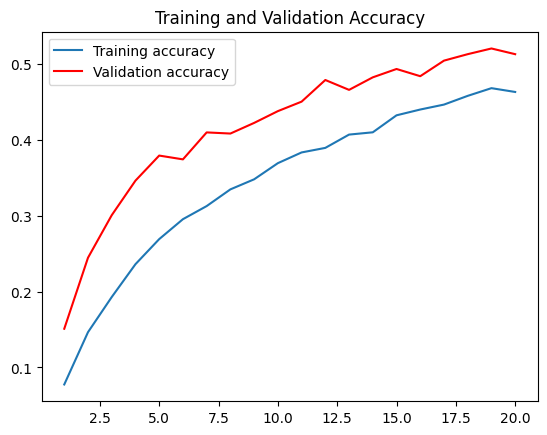

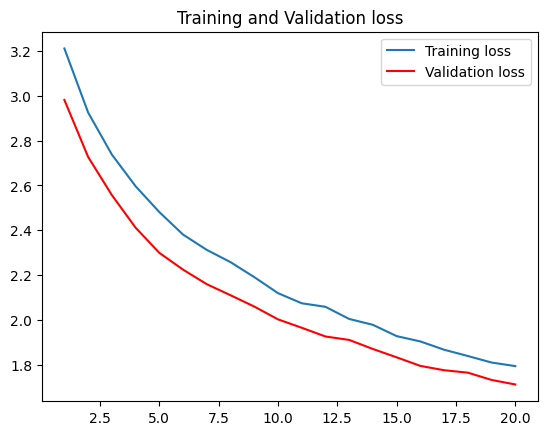

Average Validation loss:  2.0915964126586912
Average Validation accuracy: 41.87 %


In [84]:
plot_acc_loss(history)

# Fine-Tuning with Transfer Learning Using VGG16 🦉✨
* In this section, we implement fine-tuning for our model using the VGG16 architecture. 
* This technique leverages pre-trained weights to enhance performance on our specific dataset, allowing for improved accuracy in classification tasks.
Here’s how we approach this process:

## 1. Set the Convolutional Base to be Trainable 🔄
* First, we enable training for the entire convolutional base. This is crucial for allowing the model to learn from the new dataset effectively.

In [22]:
# Set the conv_base to be trainable
conv_base.trainable = True

# Set the layers from block5_conv1 to block5_conv3 to be trainable
set_trainable = False
for layer in conv_base.layers:
    # Start setting layers to trainable when reaching block5_conv1
    if layer.name == 'block5_conv1':
        set_trainable = True
        
    # Set layers to trainable if within the range
    if set_trainable and layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

# Verify which layers are trainable
for layer in conv_base.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Not trainable'}")


input_layer_2: Not trainable
block1_conv1: Not trainable
block1_conv2: Not trainable
block1_pool: Not trainable
block2_conv1: Not trainable
block2_conv2: Not trainable
block2_pool: Not trainable
block3_conv1: Not trainable
block3_conv2: Not trainable
block3_conv3: Not trainable
block3_pool: Not trainable
block4_conv1: Not trainable
block4_conv2: Not trainable
block4_conv3: Not trainable
block4_pool: Not trainable
block5_conv1: Trainable
block5_conv2: Trainable
block5_conv3: Trainable
block5_pool: Not trainable


## VGG16 Model Summary: Layer Architecture and Parameters 📊
* This section provides an overview of the VGG16 model architecture, including the types of layers, their output shapes, and the number of parameters. 
* Understanding this summary is crucial for grasping how the model processes input images and the complexity of the model.

In [23]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Freezing Layers in VGG16 for Transfer Learning🐦✨
* This code snippet configures the VGG16 model for transfer learning by freezing most layers while allowing the last three convolutional layers to remain trainable. 
* By setting trainable to False for earlier layers, the model retains pre-learned features, preventing overfitting on small datasets. 
* This strategy focuses on fine-tuning only the most relevant parts of the model, which helps in adapting the model to specific tasks while still leveraging the powerful feature extraction capabilities of VGG16. 
* The trainable status of each layer is printed, ensuring clarity on the model’s configuration📜.

In [24]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Assuming you've already defined `conv_base`
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Set the conv_base to be trainable
conv_base.trainable = True

# Set specific layers to be trainable
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable and layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

# Print which layers are trainable
for layer in conv_base.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Not trainable'}")

# Build the Sequential model
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(25, activation='softmax')
])

# Specify input shape
model.build((None, 240, 240, 3))

# Print the model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer_4: Not trainable
block1_conv1: Not trainable
block1_conv2: Not trainable
block1_pool: Not trainable
block2_conv1: Not trainable
block2_conv2: Not trainable
block2_pool: Not trainable
block3_conv1: Not trainable
block3_conv2: Not trainable
block3_conv3: Not trainable
block3_pool: Not trainable
block4_conv1: Not trainable
block4_conv2: Not trainable
block4_conv3: Not trainable
block4_pool: Not trainable
block5_conv1: Trainable
block5_conv2: Trainable
block5_conv3: Trainable
block5_pool: Not trainable


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,143,897 (80.66 MB)

 Trainable params: 13,508,633 (51.53 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Model Compilation and Training 🚀📊
* In this section, we compile the model using the Adam optimizer with a learning rate of 2e-5 for optimal convergence 🌟. 
* The loss function chosen is categorical crossentropy, suitable for multi-class classification tasks 🔍. 
* We then set the BATCH_SIZE to 32 and the number of EPOCHS to 40 to ensure thorough training 📈. 
* The model is trained on the training generator, validating its performance on the validation generator, with steps calculated based on the number of samples, enhancing the training process 📅💪.

In [25]:
from tensorflow.keras import optimizers

# Update optimizer to use 'learning_rate' instead of 'lr'
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)

BATCH_SIZE = 32
EPOCHS = 40


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
)


Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 790ms/step - acc: 0.0841 - loss: 3.1919 - val_acc: 0.2060 - val_loss: 2.7267
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 205s 778ms/step - acc: 0.2099 - loss: 2.6475 - val_acc: 0.3615 - val_loss: 2.2112
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 204s 776ms/step - acc: 0.3236 - loss: 2.2535 - val_acc: 0.4440 - val_loss: 1.8488
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 204s 777ms/step - acc: 0.4103 - loss: 1.9352 - val_acc: 0.5315 - val_loss: 1.6047
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 769ms/step - acc: 0.4894 - loss: 1.6987 - val_acc: 0.6030 - val_loss: 1.3824
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 205s 779ms/step - acc: 0.5445 - loss: 1.5130 - val_acc: 0.6200 - val_loss: 1.2860
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 770ms/step - acc: 0.5818 - loss: 1.3660 - val_acc: 0.6490 - val_loss: 1.1726
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 206s 784ms/step - acc: 0.6990 - loss: 0.9834 - val_acc: 0.7440 - val_loss: 0.8639
Epoch 12/40
250/250 ━━━━

### Accessing Class Indices and Species Names 🦜🔑
* In this step, we access the class indices from the training generator, which provides a mapping of species names to their corresponding class labels 📜. 
* By extracting the unique species names from the class indices, we create a list that helps us understand the different categories present in our dataset 🌿. 
* This is essential for interpreting model predictions and ensuring we can accurately label outputs 🎯. The unique species names are printed for verification, offering a clear overview of the classification task ahead 📊.

In [26]:
# Accessing class indices (mapping of species names to class labels)
class_indices = train_generator.class_indices

# Extracting unique species names
species_names = list(class_indices.keys())

print("Unique species names:", species_names)


Unique species names: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']


In [27]:

# Save the model in the newly created directory
model.save('/kaggle/working/finetuning_vgg16.h5')

## Saving and Moving the Fine-Tuned VGG16 Model 💾📦
This code snippet demonstrates how to save a fine-tuned VGG16 model to a specified file path and then move it to a different directory for organization and access.

* **Saving the Model:** The model is saved in the /kaggle/working/ directory as finetuning_vgg16_model.h5. A confirmation message is printed if the model is saved successfully ✅.

* **Creating Output Directory:** It checks for the existence of an /kaggle/output directory and creates it if it doesn't exist, ensuring a proper destination for file management 🗂️.
 
* **Moving the Model File:** If the model is found, it's moved to the /kaggle/output directory using shutil.move, helping to keep the working directory tidy 🏷️.
 
* **Verifying File Locations:** Finally, the code lists the contents of both directories to confirm that the model has been moved correctly and is accessible where needed 📜🔍.

In [33]:
import os
import shutil
from tensorflow.keras.models import save_model

# Specify the file path
save_path = '/kaggle/working/finetuning_vgg16_model.h5'

# Save the model
model.save(save_path)

# Verify if the file exists in the /kaggle/working directory
if os.path.exists(save_path):
    print("Model saved successfully in /kaggle/working.")
else:
    print("Model not found in /kaggle/working. Attempting to move.")

# Check if /kaggle/output exists, create it if not
output_dir = '/kaggle/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Move the file using shutil if needed
target_path = os.path.join(output_dir, 'finetuning_vgg16_model.h5')
shutil.move(save_path, target_path)

# Verify by listing files in both directories
print("Contents of /kaggle/working:", os.listdir('/kaggle/working/'))
print("Contents of /kaggle/output:", os.listdir('/kaggle/output/'))


Model saved successfully in /kaggle/working.
Contents of /kaggle/working: ['.virtual_documents', 'finetuning_vgg16.h5', 'bird_vgg_recognition_model.h5', 'limited_dataset2']
Contents of /kaggle/output: ['finetuning_vgg16_model.h5']


In [34]:
model.save('/kaggle/working/finetuning_vgg16_model.h5')



# List files in the /kaggle/working/ directory
print(os.listdir('/kaggle/working/'))


['.virtual_documents', 'finetuning_vgg16.h5', 'finetuning_vgg16_model.h5', 'bird_vgg_recognition_model.h5', 'limited_dataset2']


## Model Prediction and Evaluation 📊
This code demonstrates how to make predictions on a test dataset using a trained model:

* **Setup:** Initializes lists to store predicted and actual class indices.
* **Predictions:** Iterates through test data in batches, predicts classes, and appends results to the lists.
* **Visualization:** Displays the first five images with their predicted and actual labels.
* **Accuracy Calculation:** Computes and prints the accuracy of the model on the test set.

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step 


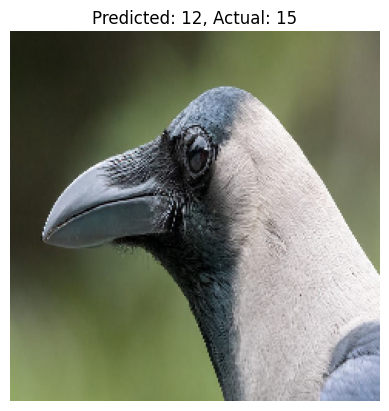

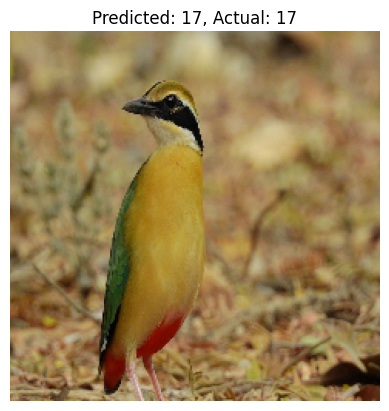

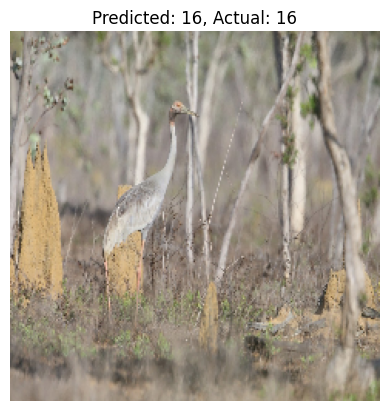

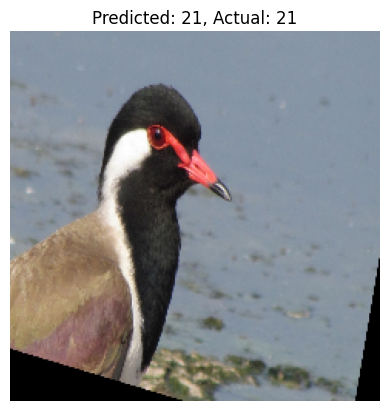

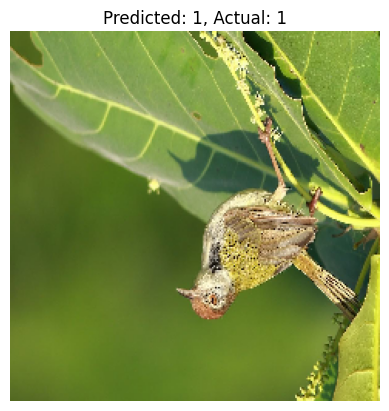

Accuracy on test set: 86.75%


In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples in the test generator
num_samples = test_generator.samples

# Initialize an empty list to store predictions and actual labels
predictions_list = []
labels_list = []

# Make predictions on the test set
for i in range(num_samples // test_generator.batch_size):
    # Get a batch of images and labels
    imgs, labels = next(test_generator)
    
    # Make predictions on the batch
    preds = model.predict(imgs)
    
    # Store the predicted classes and actual classes
    predicted_classes = np.argmax(preds, axis=1)  # Get the predicted class indices
    predictions_list.extend(predicted_classes)
    labels_list.extend(np.argmax(labels, axis=1))  # Get actual class indices

# Convert lists to arrays for easier manipulation
predictions_array = np.array(predictions_list)
labels_array = np.array(labels_list)

# Display some of the predictions
for i in range(5):  # Display the first 5 predictions
    plt.imshow(imgs[i])  # Show the image
    plt.title(f'Predicted: {predictions_array[i]}, Actual: {labels_array[i]}')  # Title with prediction and actual
    plt.axis('off')
    plt.show()

# Optionally: Calculate accuracy
accuracy = np.sum(predictions_array == labels_array) / len(labels_array)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')


## Plotting Training and Validation Metrics 📊
This function visualizes the training and validation accuracy and loss:

* **Extracts Metrics:** Retrieves training/validation accuracy and loss from the history.
* **Plots Accuracy:** Displays training vs. validation accuracy.
* **Plots Loss:** Shows training vs. validation loss.
* **Outputs Averages:** Prints average validation loss and accuracy for quick performance assessment.

In [30]:
def plot_acc_loss(history):

    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc)+1)

    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='red')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color='red')
    plt.title("Training and Validation loss")
    plt.legend()
    plt.show()
    print("Average Validation loss: ", np.mean(val_loss))
    print(f"Average Validation accuracy: {np.mean(val_acc)*100:.2f} %")

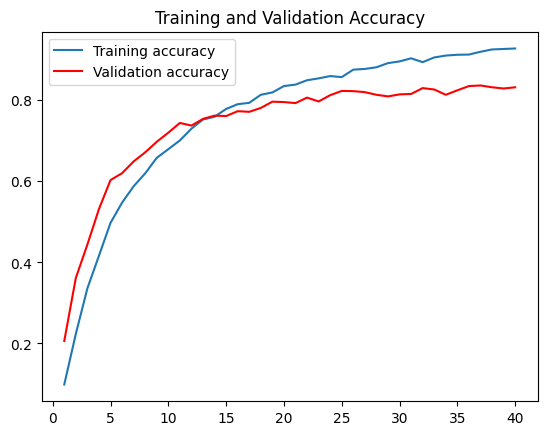

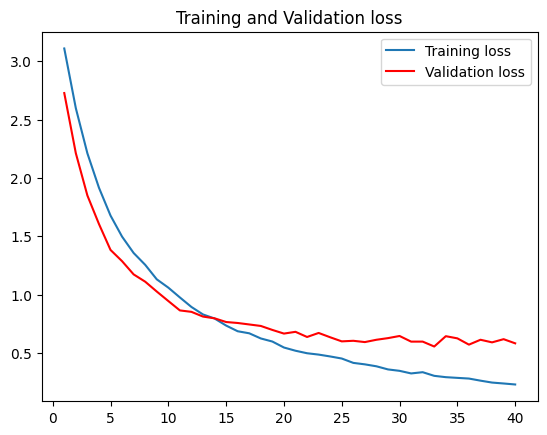

Average Validation loss:  0.8820693761110305
Average Validation accuracy: 73.92 %


In [31]:
plot_acc_loss(history)